### Imports

In [1]:
import copy
import glob
import importlib
import math
import operator
import os
import shutil
import time
import re
from math import ceil, floor
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage.morphology
import skimage.measure

import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import voi_methods as vm
import seg_methods as sm
import random

%matplotlib inline
np.set_printoptions(3)

Using TensorFlow backend.


In [4]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Generate data

### Load DCM

In [73]:
accnum = "E105490014"
if hasattr(C, 'dcm_dirs'):
    cls = 'hcc'
    cls_num = C.cls_names.index(cls)
    load_dir = join(C.dcm_dirs[cls_num], accnum)
else:
    load_dir = join(C.dcm_dir, accnum)

In [76]:
drm.open_dcm_folder(cls, accnum)

In [77]:
importlib.reload(hf)
art, D = hf.dcm_load(join(load_dir, C.phase_dirs[0]), flip_x=False, flip_y=False)
ven, E = hf.dcm_load(join(load_dir, C.phase_dirs[1]), flip_x=False, flip_y=False)
eq, _ = hf.dcm_load(join(load_dir, C.phase_dirs[2]), flip_x=False, flip_y=False)

art.shape, ven.shape, eq.shape

((512, 512, 112), (512, 512, 112), (512, 512, 96))

In [78]:
eq, E = hf.dcm_load(join(load_dir, C.phase_dirs[2]))#, flip_z=True)

In [82]:
eq = eq[...,1:-1]
eq2 = tr.rescale_img(eq, (512, 512, 112))

In [143]:
importlib.reload(hf)
art, D = hf.dcm_load(r"Z:\Sophie\Etiologyproject\Additional MRIs\E104515795\art_603", flip_x=False, flip_y=False)
ven, E = hf.dcm_load(r"Z:\Sophie\Etiologyproject\Additional MRIs\E104515795\pv_604", flip_x=False, flip_y=False)
eq, _ = hf.dcm_load(r"Z:\Sophie\Etiologyproject\Additional MRIs\E104515795\delayed_606", flip_x=False, flip_y=False)

In [ ]:
print(load_dir)

In [144]:
art = np.mean(art,-1)
ven = np.mean(ven,-1)
eq = np.mean(eq,-1)

In [87]:
os.makedirs(join(load_dir, "nii_dir"))

In [129]:
hf.save_nii(art, join(load_dir, "nii_dir", "20s.nii.gz"), D)
hf.save_nii(ven, join(load_dir, "nii_dir", "70s.nii.gz"), D)
hf.save_nii(eq, join(load_dir, "nii_dir", "3min.nii.gz"), D)

In [117]:
art,_ = hf.nii_load(join(load_dir, "nii_dir", "20s.nii.gz"))
ven,_ = hf.nii_load(join(load_dir, "nii_dir", "70s.nii.gz"))
eq,_ = hf.nii_load(join(load_dir, "nii_dir", "3min.nii.gz"))

In [119]:
accnums=["4750142"]
#load_dir = join(C.dcm_dirs[0], accnums[0])
#masks.off2ids(join(load_dir, 'Segs', 'tumor_20s.off'), R=[2,2,3])
importlib.reload(drm)
drm.dcm2npy(accnums=accnums, overwrite=True)
drm.tricolorize(accnums)
vm.extract_seg_vois(accnums)
vm.save_seg_set(accnums, num_cores=1)

In [ ]:
hf.split_dcm(join(load_dir, C.phase_dirs[2]))
shutil.rmtree(join(load_dir, C.phase_dirs[1]))
shutil.rmtree(join(load_dir, C.phase_dirs[2]))
shutil.rmtree(join(load_dir, C.phase_dirs[2])+"_bin0")
os.rename(join(load_dir, C.phase_dirs[2])+"_bin1", join(load_dir, C.phase_dirs[1]))
os.rename(join(load_dir, C.phase_dirs[2])+"_bin2", join(load_dir, C.phase_dirs[2]))

In [145]:
#art = tr.rescale_img(art, E, D)
#eq = tr.rescale_img(eq, E, D)

importlib.reload(hf)
hf.create_dicom(art, join(load_dir, C.phase_dirs[0]), E, True)
hf.create_dicom(ven, join(load_dir, C.phase_dirs[1]), E, True)
hf.create_dicom(eq, join(load_dir, C.phase_dirs[2]), E, True)

### Load npys

In [9]:
vm.save_vois_as_imgs(save_dir='/home/idealab/Documents/Clinton/LIRADS/screenshots', separate_by_cls=False)

/home/idealab/anaconda3/envs/clinton/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/idealab/anaconda3/envs/clinton/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
importlib.reload(drm)
src_data_df = drm.get_coords_df()
accnum_df = drm.get_accnum_df()
lesion_df = drm.get_lesion_df()

/home/idealab/Documents/Clinton/voi-classifier/python/dr_methods.py:622: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([pd.read_excel(C.coord_xls_path, C.sheetnames[C.cls_names.index(cls)], sort=False) for cls in C.cls_names])


In [102]:
vm.remove_lesion_id("E102881031_2")

root = C.dcm_dirs[C.cls_names.index(cls)]
load_dir = join(root, accnum)
art,D = hf.dcm_load(join(load_dir, C.phase_dirs[0]))

In [ ]:
lesion_df.loc["E102881031_2"]

In [85]:
cls = 'hemangioma'
src_data_df = drm.get_coords_df(cls)
#accnums = ['E105490014']
accnums = list(set(src_data_df['acc #'].values))#list(set(src_data_df.loc[src_data_df["Run"] > 2, 'acc #'].values))

cls = None
accnums = ['E103001171', 'E103510187', 'E102375251', 'E101681012']#src_data_df.loc[src_data_df["Flipped"] == "Yes", 'acc #'].values

In [ ]:
importlib.reload(drm)
drm.dcm2nii(cls, accnums)

In [7]:
importlib.reload(drm)
drm.dcm2npy(cls, accnums, overwrite=True)

In [ ]:
importlib.reload(vm)
vm.load_accnum(cls, accnums)

In [ ]:
drm.dcm2npy(cls, accnums, overwrite=True)
vm.load_accnum(cls, accnums)

In [6]:
for cls in C.cls_names:
    src_data_df = drm.get_coords_df(cls)
    accnums = list(set(src_data_df['acc #'].values))
    #drm.dcm2npy(cls, accnums, overwrite=True)
    vm.load_accnum(cls, accnums)

.............................................................................................................................................................................................................hcc 63.01622557640076
...........................................................................................................cholangio 192.49407386779785
...................................................................................................................................colorectal 86.15927743911743
....................................................................................................................cyst 48.76239085197449
....................................................................................................................................hemangioma 117.92196893692017
.............................................................................................................................................fnh 115.73255777359009


In [ ]:
importlib.reload(drm)
drm.load_vois(cls, accnums, overwrite=True)
vm.extract_vois(cls, accnums, overwrite=True)

In [ ]:
importlib.reload(vm)
vm.save_unaugmented_set(cls, accnums, overwrite=True)
vm.save_augmented_set(cls, accnums, overwrite=True)

In [144]:
drm.open_dcm_folder(cls,'13092836')

In [ ]:
accnums.index('E105152299')

In [95]:
vm.save_vois_as_imgs(save_dir="D:\\Etiology\\screenshots")

In [378]:
lesion_df = drm.get_lesion_df()
vm.save_vois_as_imgs(cls=cls, lesion_ids=lesion_df[lesion_df["run_num"]>2].index, save_dir="E:\\check_these")

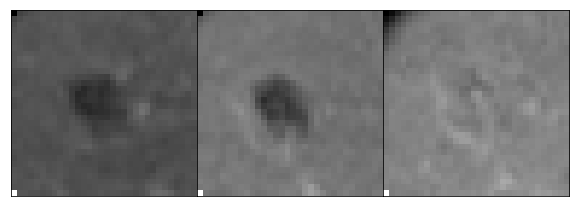

In [99]:
importlib.reload(vm)
I=vm.plot_check(2, accnums[1]+"_0", slice_frac=.5);

In [ ]:
vm.plot_check(1, "12053486_0", None, slice_frac=.5);

In [ ]:
lesion_df.loc["E106097366_0"]

#### JHU Etiology

In [ ]:
importlib.reload(drm)
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
drm.build_coords_df(accnum_xls_path)

In [ ]:
input_df = pd.read_excel(accnum_xls_path,
             sheetname="Prelim Analysis Patients", index_col=0, parse_cols="A,J")
accnum_dict = {category: list(input_df[input_df["Category"] == category].index.astype(str)) for category in C.sheetnames}
accnum_dict["HBV"]

In [133]:
accnum = "2435642"
load_dir = join(C.dcm_dirs[0], accnum)

In [37]:
I = np.load(join(C.full_img_dir, accnum+"_tumorseg.npy"))

In [ ]:
t = time.time()
masks.off2ids(join(load_dir, 'Segs', 'liver.off'), R=[2,2,3], num_foci=1)
print(time.time() - t)

In [10]:
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
input_df = pd.read_excel(accnum_xls_path,
             sheetname="Prelim Analysis Patients", index_col=0, parse_cols="A,J")

accnum_dict = {category: list(input_df[input_df["Category"] == category].index.astype(str)) for category in C.sheetnames}
accnum_dict['Nonviral'] = accnum_dict["Nonviral"][37:]
accnum_dict.pop('HBV');
accnum_dict.pop('HCV');

In [ ]:
importlib.reload(drm)
accnum_xls_path = r"C:\Users\Clinton\Box\Rad-Etiology Correlation\hklc_master.xlsx"
drm.off2ids_batch(accnum_dict=accnum_dict)

In [140]:
off_path=join(base_dir, "1800356", "Segs", "tumor_20s.off")

In [141]:
importlib.reload(masks)
masks.off2ids(off_path)

### Vois

In [313]:
cls = "HBV"
I_path = glob.glob(join(C.full_img_dir, cls, "*"))[0]
cI_path = glob.glob(join(C.crops_dir, cls, "*"))[0]
lesion_id = basename(fn)[:-4]
accnum = lesion_id[:lesion_id.find('_')]
load_dir = join(C.dcm_dirs[0], accnum)

In [301]:
off_path = join(load_dir, "Segs", "tumor_20s.off")
masks.off2ids(off_path)

importlib.reload(masks)
M_path = glob.glob(join(load_dir, "Segs", "*_0.ids"))[0]

In [294]:
importlib.reload(masks)
M = masks.crop_img_to_mask_vicinity(join(load_dir, 'T1_20s'), M_path, padding=.5, add_mask_cont=True)

In [237]:
masks.create_dcm_with_mask(join(load_dir, 'T1_20s'), M_path, "D:\\Test", overwrite=True)

In [ ]:
importlib.reload(vm)
[vm.reset_accnum(x) for x in ["12807018"]];

In [ ]:
vm.save_augmented_set(cls="nonviral", overwrite=False)

In [ ]:
df = pd.concat([pd.read_excel(C.coord_xls_path, sheetname) for sheetname in C.sheetnames])

In [ ]:
importlib.reload(vm)
vm.xref_dirs_with_excel(fix_inplace=False)

# Plotting

In [10]:
importlib.reload(vm)
vm.save_vois_as_imgs(save_dir='/home/idealab/Documents/Clinton/screenshots', normalize=[-1,1], separate_by_cls=False)

/home/idealab/anaconda3/envs/clinton/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/idealab/anaconda3/envs/clinton/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [35]:
accnum = "4252236"
load_dir = join(C.dcm_dirs[0], accnum)

art,D = hf.load_img(join(load_dir, "nii_dir", "20s.nii.gz"))#hf.dcm_load(join(load_dir, C.phase_dirs[0]))
ven,_ = hf.load_img(join(load_dir, "nii_dir", "70s.nii.gz")) #hf.dcm_load(join(load_dir, C.phase_dirs[1]))[0]
eq,_ = hf.load_img(join(load_dir, "nii_dir", "3min.nii.gz")) #hf.dcm_load(join(load_dir, C.phase_dirs[2]))[0]

In [ ]:
for fn in glob.glob(r"D:\Etiology\Imaging\*\T1_20s")[512:]:
    try:
        load_dir = dirname(fn)
        accnum = basename(load_dir)
        art,D = hf.load_img(join(load_dir, "T1_20s"))
        ven,_ = hf.load_img(join(load_dir, "T1_70s"))
        eq,_ = hf.load_img(join(load_dir, "T1_3min"))
    except:
        continue
        
    try:
        if exists(join(load_dir, "nii_dir")):
            shutil.rmtree(join(load_dir, "nii_dir"))
            time.sleep(0.01)
        os.makedirs(join(load_dir, "nii_dir"))
        hf.save_nii(art, join(load_dir, "nii_dir", "20s.nii.gz"), D)
        hf.save_nii(ven, join(load_dir, "nii_dir", "70s.nii.gz"), D)
        hf.save_nii(eq, join(load_dir, "nii_dir", "3min.nii.gz"), D)
        
        art, ven, eq, slice_shift = reg.crop_reg(art, ven, eq)
        img = np.stack((art, ven, eq), -1)
        
        downsample = 1
        if np.product(art.shape) > C.max_size:
            downsample = 2
            img = tr.scale3d(img, [1/downsample, 1/downsample, 1])
            D = [D[0]*downsample, D[1]*downsample, D[2]]

        np.save(join(C.full_img_dir, accnum+".npy"), img)
        sm.save_segs([accnum], downsample, slice_shift, art.shape[-1])
    except:
        raise ValueError(accnum)

In [ ]:
importlib.reload(drm)
cls = "hbv"
acc_num = '790003'
img = np.load(C.full_img_dir+"\\"+cls + "\\"+acc_num + ".npy")
vis.draw_flipped_slices(img, voi_df_art[(voi_df_art["acc_num"] == acc_num) & (voi_df_art["cls"] == cls)].iloc[0])
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

In [61]:
importlib.reload(vm)
[vm.reset_accnum(x[:-2]) for x in ['13010227_0', 'E105993177_0',
 'E100852770_0', 'E103835733_0', '12888679_0', 'E100458776_0', 'E100894274_0']]

.......

[None, None, None, None, None, None, None]

-0.9749059606481485 0.9052014807754605 -0.0664152584179922


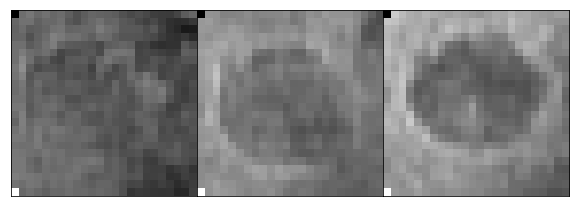

In [38]:
importlib.reload(vm)
img = vm.plot_check(2, "13216353", normalize=[-1,1])
print(np.amin(img), np.amax(img), np.mean(img))

In [ ]:
for cls in C.classes_to_include:
    print(cls)
    print('\n'.join([x[:-4] for x in os.listdir("E:\\lesion_imgs_small\\"+cls)]))
    #vm.save_vois_as_imgs(cls=cls, save_dir="E:\\lesion_imgs_small\\"+cls, fn_suffix="")

In [294]:
lids = ['E106097391_0.npy', 'E104978772_1.npy', '12900535_0.npy', 'E100150242_0.npy', 'E105490014_0.npy', 'E103147618_0.npy', 'E103510187_0.npy', 'E104657225_0.npy', 'E100551966_0.npy', 'E101388602_0.npy', 'E100215900_8.npy', 'E100215900_7.npy', 'E104045692_0.npy', '13104521_0.npy', 'E100383453_0.npy', '12943286_0.npy', '12271995_0.npy', 'E102315724_0.npy', 'E104949189_0.npy', 'E100511083_1.npy', 'E101579471_0.npy', '13018986_1.npy', '13203550_8.npy', '13112385_0.npy', '12712463_0.npy', '12361082_0.npy', '13028374_0.npy', 'E103985934_1.npy', 'E100529980_0.npy', '12042703_3.npy', '12961059_0.npy', 'E105724706_2.npy', 'E100592424_2.npy', 'E103104254_0.npy', 'E104546069_0.npy', 'E101665217_1.npy', '12090000_0.npy', 'E100592424_1.npy', '12961059_1.npy', 'E105474285_0.npy', '12502068_1.npy', 'E100814791_0.npy', 'E102613189_0.npy', 'E105427046_0.npy', 'E102881031_1.npy', 'E102929168_0.npy', 'E102310482_0.npy', 'E102095465_0.npy', 'E101811299_0.npy', 'E104737273_0.npy', '12890053_0.npy', 'E100168661_1.npy', '12637865_0.npy', 'E100168661_2.npy', '12239783_0.npy', '12707781_0.npy', '12706568_1.npy', '12823036_0.npy', '12404081_0.npy', '12365693_1.npy']

In [301]:
lids = ['13018986_1', '13203550_8', 'E100168661_1', '12706568_1', 'E104189184_0', 'E100215900_7', '12900535_0', 'E100551966_0',
       'E102310482_0', 'E102095465_0', 'E105474285_0', 'E105724706_2']

In [32]:
misclass_img = ['E100610622_0', '12788616_0', '13092836_2', 'E100407633_0', 'E103312835_1', 'E103020139_1']

In [ ]:
vm.save_imgs_with_bbox(lesion_ids=misclass_img, save_dir="E:\\Z_test", separate_by_cls=False)

In [8]:
importlib.reload(vm)
save_dir = "D:\\Paula-project\\screenshots"
#save_dir = "E:\\lesion_imgs_small"
vm.save_vois_as_imgs(save_dir=save_dir, separate_by_cls=True, normalize=[-1,1])

# Generate reader study samples

In [24]:
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()

In [120]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']

banned_accnums = [z[:z.find('_')] for z in Z_reader]

voi_reader = voi_df_art[voi_df_art["id"].isin(Z_reader)]#voi_df_art[voi_df_art.index.isin(Z_reader)]

In [260]:
f_map = {}
b_map = {}
cls_map = {}

for cls in C.classes_to_include:
    for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
        img_id = str(sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])
        acc_num = row["Filename"][:-4] #row["acc_num"]
        f_map[row["id"]] = img_id
        b_map[img_id] = row["id"]#acc_num
        cls_map[row["id"]] = row["cls"]#acc_num
        #if cls == "fnh":#img_id == "4613":
        print("Z:\\DICOMs\\" + cls + "\\" + acc_num, 
              row["x1"], row["x2"], row["y1"], row["z1"], "---", img_id)
        try:
            print(b_map[img_id])
        except:
            pass

#f_map['E100199185'] = '46130'
#b_map['4613'] = "12678910_1"
#b_map['46130'] = "E100199185_0"

In [262]:
with open('Z:\\answer_key.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for k in Z_reader:
        writer.writerow([k, f_map[k], cls_map[k]])

In [ ]:
hitlist = []
replacements = []

for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047'] + ['4354', '3049', '5438'] + ['46130']:#['4158', '5720', '46130', '7444']:
    print(cls_map[b_map[secret_id]])
    hitlist.append(b_map[secret_id])
    replacements.append(cls_map[b_map[secret_id]])

In [165]:
for secret_id in ['4181', '2858', '3505', '4194', '2821', '5912', '5047']:
    base_dir = r"Z:\Inter-reader study\DICOMs"
    shutil.move(os.path.join(base_dir, secret_id), os.path.join(base_dir, "Unused", secret_id))

In [33]:
multi_accnums = [accnum for accnum, count in zip(*np.unique(list(b_map.values()), return_counts=True)) if count>1]
print(multi_accnums)

In [276]:
for _, row in voi_reader.iterrows():
    cls = row["cls"]
    acc_num = str(row["Filename"])[:-4]
    for protocol in ["T1_AP", "T1_VP", "T1_EQ"]:
        target_dir = os.path.join("Z:\\Inter-reader study\\DICOMs\\extras", row['id'], protocol)
        shutil.copytree(os.path.join("Z:\\DICOMs", cls, acc_num, protocol), target_dir)

In [ ]:
for acc_num in f_map:
    try:
        os.rename(os.path.join("Z:\\Inter-reader study\\DICOMs", acc_num),
                  os.path.join("Z:\\Inter-reader study\\DICOMs", f_map[acc_num]))
    except Exception as e:
        print(acc_num, e)

# Read Run Stats

In [64]:
a = ['E106158268_0','E102424706_0','12570256_0','E100574689_0','E106120112_0','E100899012_0','E103678771_0','E105095742_0','E100899012_1','13278054_0','E100834987_0','13094833_0','E102088195_1','E101554830_0','12801670_0','E100304876_1','13013150_0','12807018_0','E101449797_0','12249331_0','E101686218_0','12993437_1','E101158768_0','E101356604_0','E105124678_0','12993437_0','E100793044_0','E104587275_0','E104099161_0','E105152299_0','E102031795_1','E100623842_0','E102388865_0','E103301795_0','E100814791_0','13160747_0','E101880575_0','12248774_1','12914169_0','E101442376_0','13197011_0']

In [56]:
df = pd.read_csv(r"D:\Radpath\excel\overnight_run - backup.csv")#C.run_stats_path)

In [ ]:
for cls in C.cls_names:
    for x,y in sorted_x:

In [ ]:
df = df.dropna(subset=['miscls_test'])
df = df.loc[:,['miscls_test','miscls_train']] #df.model_num.str.startswith('fixZ-ens')
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['miscls_test'].values
#mis_test += df['miscls_train'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
for x,y in sorted_x:
    print(x,y)

In [28]:
mis_test = df['miscls_train'].values
mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = mis_test.split(']')

In [58]:
mis_test = df['misclassified_train'].values

T = []
for ix in range(len(mis_test)-1):
    T.append((mis_test[ix].count(',')+1))

In [ ]:
for z in sorted_x:
    print(z[0],'\t',z[1])

In [18]:
vm.save_vois_as_imgs(lesion_ids=[k for k in x if x[k]>2 and k!=""], save_dir="Z:\\Paula\\Misclassifications", separate_by_cls=True, normalize=[-1,1])

df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == 10) & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] < 1515879326)]

In [68]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['hcc'] == 141) & (df['clinical_inputs'] == 2) & (df['steps_per_epoch']>100)]
#df = df[~df.model_num.str.startswith('fixZ-ens')]

In [56]:
df.acc6cls.mean(), df.acc3cls.mean()

(0.7316666666666667, 0.7316666666666667)

In [79]:
train_acc = [1-x.count("_")/434 for x in df['miscls_train'].values] #434

In [69]:
[print("%.1f%%"%(x*100)) for x in (np.mean(df.acc6cls), np.std(df.acc6cls), df.acc3cls.mean(), df.acc3cls.std())]

76.0%
6.3%
87.8%
5.0%


[None, None, None, None]

In [ ]:
76.5%
5.6%
85.5%
4.4%

In [ ]:
cms = df['confusion_matrix'].values
cms = ''.join(cms)

supercm = hf.str_to_lists(cms, dtype=int)
supercm = [supercm[rownum:rownum+C.nb_classes] for rownum in range(0,len(supercm),C.nb_classes)]
supercm = np.array(supercm)

cm_sum = np.empty((C.nb_classes,C.nb_classes), int)

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(C.nb_classes):
    for j in range(C.nb_classes):
        print(cm_sum[j,i],end='\t')
    print()

In [112]:
np.sum(cm_sum[0,:])

150.0

In [29]:
avg_tpr = cm_sum[0,0]/np.sum(cm_sum[0,:])
avg_fpr = np.sum(cm_sum[1:,0])/np.sum(cm_sum[1:,:])

In [30]:
fpr = [np.sum(cm[1:,0])/np.sum(cm[1:,:]) for cm in supercm]
tpr = [cm[0,0]/np.sum(cm[0,:]) for cm in supercm]

In [33]:
importlib.reload(hf)
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)
test_num = truths.shape[1]

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+test_num] for rownum in range(0,len(predictions),test_num)]
predictions = np.array(predictions)

hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(len(df)):
    for lesion_num in range(test_num):
        if truths[run_num, lesion_num] == C.cls_names.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+random.random()*1e-5] = 'hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            if predictions[run_num, lesion_num, 0] in thresh_dict:
                thresh_dict[predictions[run_num, lesion_num, 0]+random.random()*1e-5] = 'non-hcc'
            else:
                thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

In [37]:
len(thresh_dict)

300

In [38]:
minT = [1,1] #minT=[.68,.99]

true = 50#len(thresh_dict)//2
false = 300-50#len(thresh_dict)//2
TPR = [true/true]
FPR = [false/false]
a=0
hcc_correct = 50#len(thresh_dict)//2
hcc_wrong = 300-50#len(thresh_dict)//2
for key in sorted(thresh_dict):
    if key > minT[1]:
        break
    if key > minT[0]:
        a+=1
        if thresh_dict[key] != 'hcc':
            hcc_wrong -= 1
    elif thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/true)
    FPR.append(hcc_wrong/false)

In [39]:
R = (1-FPR[-1], TPR[-1])
R

(1.0, 0.0)

In [186]:
a/len(thresh_dict)

0.6206666666666667

In [180]:
hcc_fpos_cost = 12000
hcc_miss_cost = 5000
biopsy_cost = 1400

In [81]:
nonhcc_thresh = np.array(nonhcc_thresh)
hcc_thresh = np.array(hcc_thresh)
all_thresh = np.array(list(thresh_dict.keys()))

In [178]:
(hcc_thresh < minT[0]).sum()

11

In [183]:
(nonhcc_thresh > minT[1]).sum()

0

In [200]:
true_spec = (nonhcc_thresh < minT[0]).sum() / (750 - ((nonhcc_thresh < minT[1]) & (nonhcc_thresh > minT[0])).sum())
true_sens = (hcc_thresh > minT[1]).sum() / (750 - ((hcc_thresh < minT[1]) & (hcc_thresh > minT[0])).sum())
true_spec, true_sens

(1.0, 0.0)

In [155]:
fun = lambda T: hcc_fpos_cost * (nonhcc_thresh > T[1]).sum() + hcc_miss_cost * (hcc_thresh < T[0]).sum() + \
        biopsy_cost * ((all_thresh < T[1]) & (all_thresh > T[0])).sum()

In [165]:
import math

In [198]:
minC=1e10
for T1 in np.linspace(0,1,100,False):
    for T2 in np.linspace(T1,1,(1-T1)*100+1):
        C = fun([T1,T2])
        if minC > C:
            minC = C
            minT = [T1,T2]

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
rates05, (avg_fpr, avg_tpr), rates95

((0.25066666666666665, 0.9786666666666667),
 (0.18, 0.9266666666666666),
 (0.12533333333333332, 0.7893333333333333))

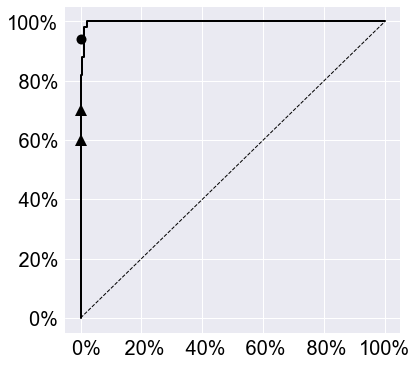

In [41]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(FPR, TPR, 'k', label='Model', linewidth=2)
#ax.plot(.04, 1, 'ko', label='ModelReader', markersize=12)
ax.plot(0, .7, 'k^', label='RAD2', markersize=12)
ax.plot(0, .6, 'k ^', label='RAD1', markersize=12)
ax.plot(avg_fpr, avg_tpr, 'ko', label='ModelAvg', markersize=10)
#ax.plot(rates10[0], rates10[1], 'ko', label='10%', markersize=10)
#ax.plot(rates95[0], rates95[1], 'ko', label='90%', markersize=10)
#ax.plot(rates05[0], rates05[1], 'ko', label='5%', markersize=10)
#ax.plot(rates98[0], rates98[1], 'ko', label='95%', markersize=10)
#ax.plot(fpr, tpr, 'o', ms=5)
ax.plot([0,1], [0,1], 'k--', lw=1)
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals], size=20, color='k')

#ax.xaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
#ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

In [56]:
sp.plot(FPR, TPR, 'k', label='Model', linewidth=3)
sp.plot(.1, .9, 'g^', label='Model', markersize=10)
sp.plot(.43, 1., 'r^', label='R2', markersize=10)
sp.plot(.67, 1., 'b^', label='R1', markersize=10)

In [ ]:
AUC = sum([(FPR[i]-FPR[i+1])*TPR[i] for i in range(len(FPR)-1)])
AUC

a = run_stats.loc[:,['y_true','y_pred_raw']]
a = a.dropna()
b = a.iloc[0]['y_pred_raw']
b = hf.str_to_lists(b)